# Decode cypher text

### Welcome!
This notebook can decode cypher text. It uses a DFA created by the method outlined here
[Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576).

In this notebook will automatically train an RNN on symplfied set of english, and extract a DFA from that RNN.


# Code below

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Extraction import extract
import time
from memory_profiler import profile
import FalseWordGenerator as FWG

import ALPHABET_7
ALPHABET = ['e','t','a','o','s','i','n']


In [2]:
MEANINGFUL_WORDS = ALPHABET_7.WORDS

MEANINGLESS_WORDS = FWG.generateFalseWords(ALPHABET, MEANINGFUL_WORDS)

def target(w):             
   if w.lower() in MEANINGFUL_WORDS:
      return True
   else:
      return False
    
train_set = {}
train_set.update({w: True for w in MEANINGFUL_WORDS})
train_set.update({w: False for w in MEANINGLESS_WORDS})
print ("made training set of size: " + str(len(train_set)))
print ("of which " + str(len(MEANINGFUL_WORDS)) + str(" are positive"))
print ("of which " + str(len(MEANINGLESS_WORDS)) + str(" are negative"))

made training set of size: 1354
of which 1023 are positive
of which 950 are negative


# Train and extract with a small network

In [10]:
rnnSmall = RNNClassifier(ALPHABET,num_layers=2,hidden_dim=5,RNNClass = LSTMNetwork)

current average loss is:  0.47799444613249403
current average loss is:  0.3979078747224117
current average loss is:  0.3694553040075993
current average loss is:  0.3544424637504246
current average loss is:  0.34364041919293614


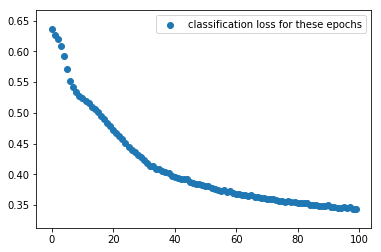

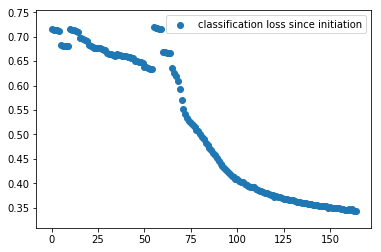

current average loss is:  0.33631659663000774
current average loss is:  0.33248346905375636
current average loss is:  0.32840469271637673
current average loss is:  0.32435820823492006
current average loss is:  0.3203790575958962


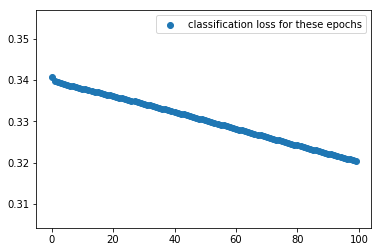

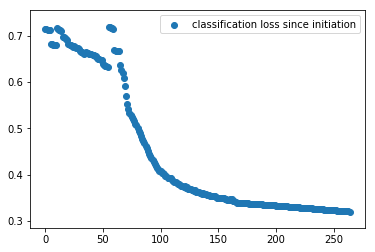

current average loss is:  0.31742613281028853
current average loss is:  0.307895935445592
current average loss is:  0.2994194180205248
current average loss is:  0.29084777603114853
current average loss is:  0.28489164861216065


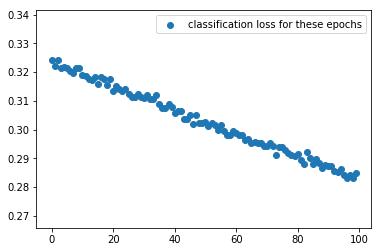

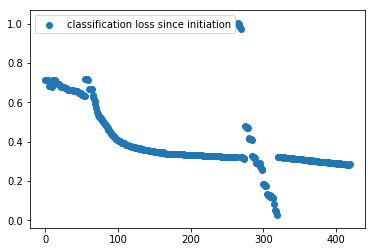

current average loss is:  0.27453823976738506
current average loss is:  0.2710369686747706
current average loss is:  0.26740566519803777
current average loss is:  0.263837969580362
current average loss is:  0.2603112376013467


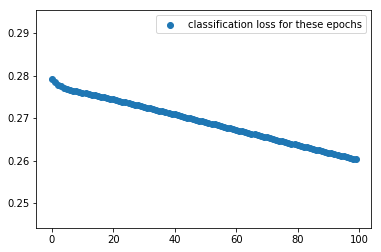

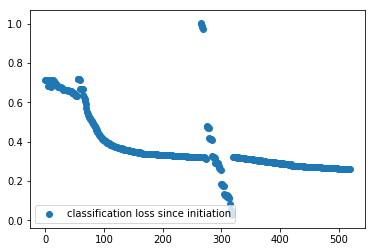

current average loss is:  0.25872560087321467
current average loss is:  0.2519511894039485
current average loss is:  0.24751793439837466
current average loss is:  0.2393606991871544
current average loss is:  0.2351801714171534


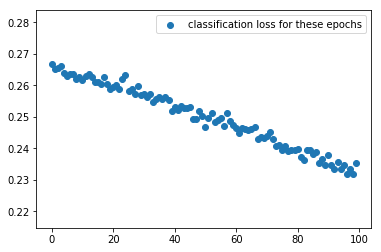

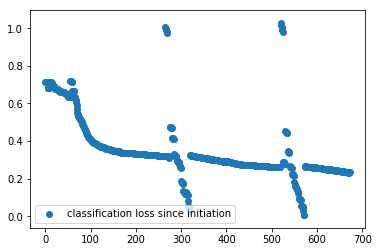

current average loss is:  0.22162869919178096
current average loss is:  0.2181147198344386
current average loss is:  0.21462888495866642
current average loss is:  0.21121517447538155
current average loss is:  0.20781097855678823


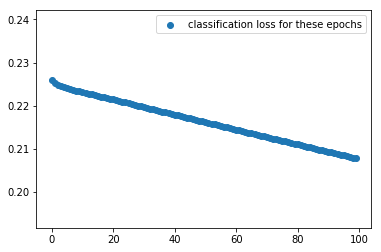

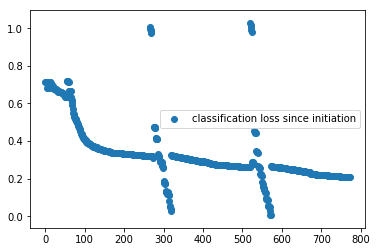

classification loss on last batch was: 0.20781097855678823


In [11]:
mixed_curriculum_train(rnnSmall,train_set,stop_threshold = 0.05)

In [12]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnnSmall.classify_word(w)==True),None)
neg = next((w for w in all_words if rnnSmall.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]

In [13]:
rnnSmall.renew()

provided counterexamples are: ['s', 'i']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 2


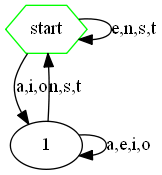

['', 'e']
['', 'e', 't']
['', 'e', 't', 'a']
refining, H size is 3
split wasn't perfect: gotta start over
['t', 'n']
returning counterexample of length 2:		ee, this counterexample is rejected by the given RNN.
equivalence checking took: 0.10287815699996372
obs table refinement took 0.01
guided starting equivalence query for DFA of size 5


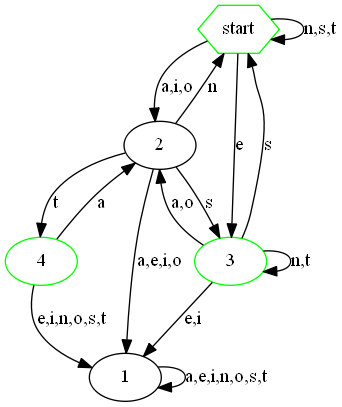

['t', 'n']
['ee', 'ea']
refining, H size is 1
['ee', 'ei']
['t', 'n', 'tt']
returning counterexample of length 2:		ta, this counterexample is accepted by the given RNN.
equivalence checking took: 0.05573639900001126
obs table refinement took 0.048
guided starting equivalence query for DFA of size 10


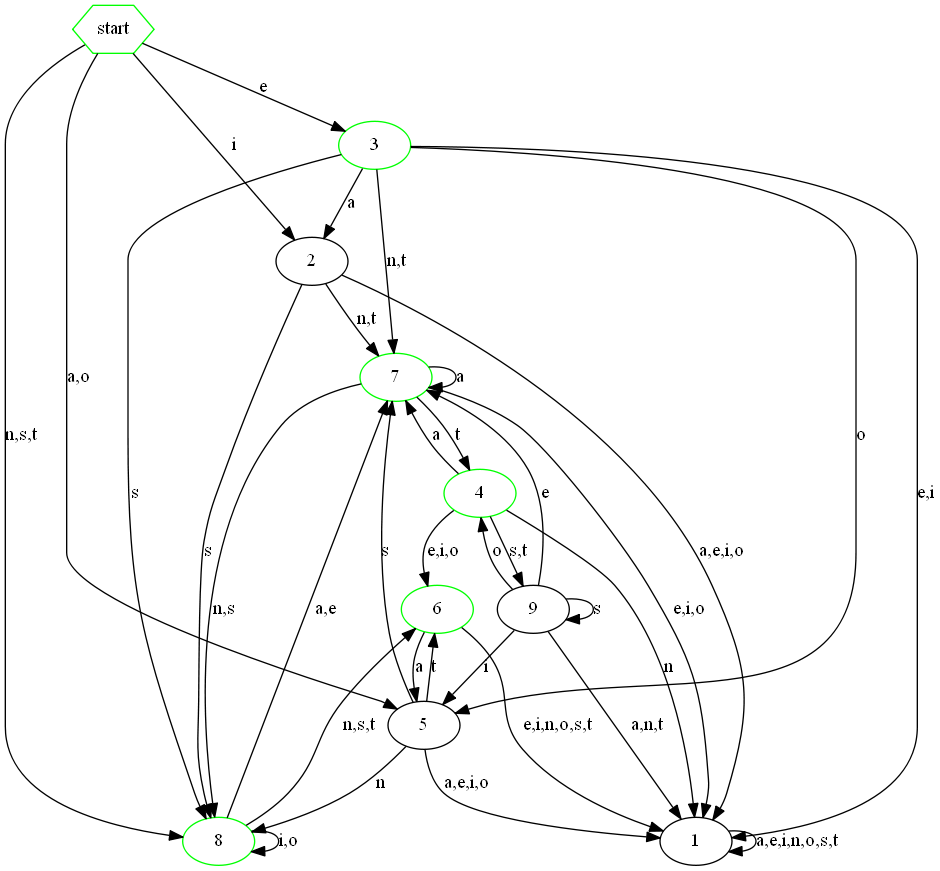

['t', 'n']
['ee', 'ei']
['t', 'n', 'tt']
refining, H size is 2
['te', 'ti']
returning counterexample of length 4:		tist, this counterexample is accepted by the given RNN.
equivalence checking took: 0.11328549100005603
obs table refinement took 0.214
guided starting equivalence query for DFA of size 26


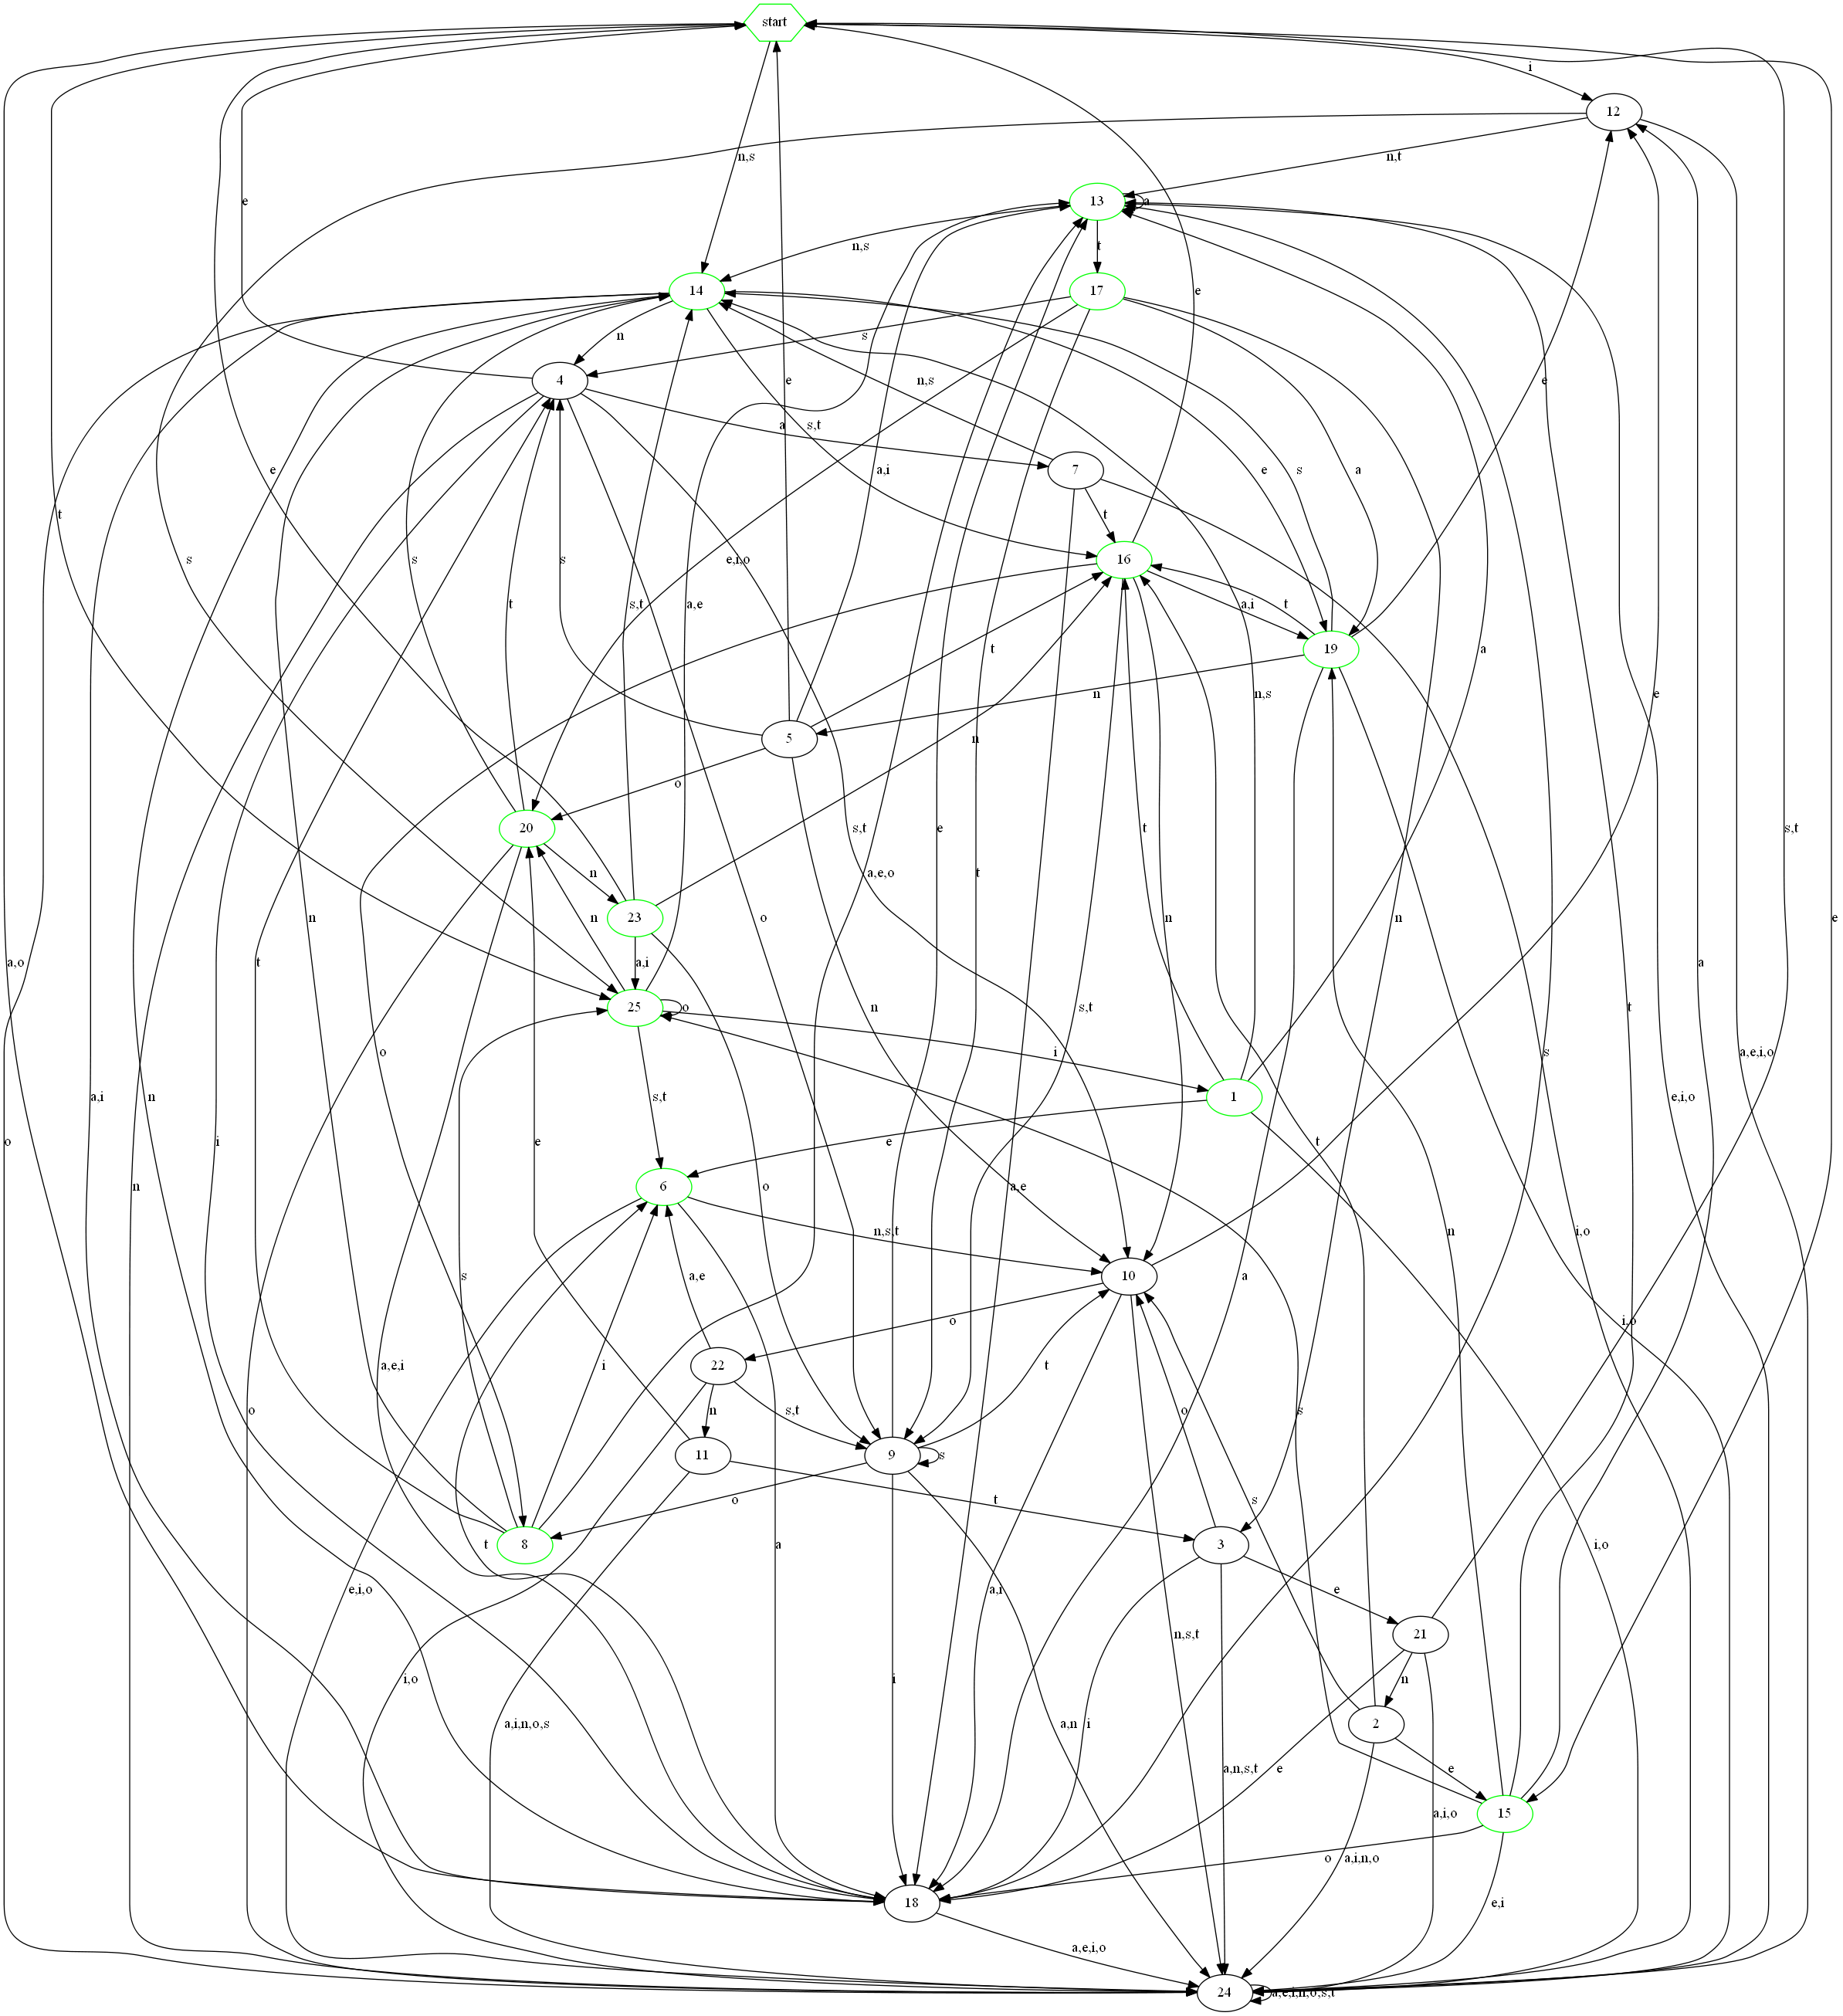

['t', 'n']
returning counterexample of length 2:		ni, this counterexample is accepted by the given RNN.
equivalence checking took: 0.8868780219999053
obs table refinement took 0.821
guided starting equivalence query for DFA of size 67
['t', 'n']
returning counterexample of length 3:		tea, this counterexample is accepted by the given RNN.
equivalence checking took: 0.0030796610000152214
obs table refinement took 12.917
guided starting equivalence query for DFA of size 289
['t', 'n']
returning counterexample of length 6:		nenina, this counterexample is accepted by the given RNN.
equivalence checking took: 0.00422425099998236
obs table timed out
observation table timed out during refinement
overall guided extraction time took: 120.07765043400002
generated counterexamples were: (format: (counterexample, counterexample generation time))
('ee', 0.10287815699996372)
('ta', 0.05573639900001126)
('tist', 0.11328549100005603)
('ni', 0.8868780219999053)
('tea', 0.0030796610000152214)
('nenina', 0

In [14]:
dfaSmall = extract(rnnSmall,time_limit = 120, initial_split_depth = 10, starting_examples = starting_examples)

# Train and Extract with a deep network

In [3]:
rnnDeep = RNNClassifier(ALPHABET,num_layers=2,hidden_dim=50,RNNClass = LSTMNetwork)

The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.


current average loss is:  0.33923828682461804
current average loss is:  0.2494559405794467
current average loss is:  0.14333789660662843
current average loss is:  0.06553353253518039


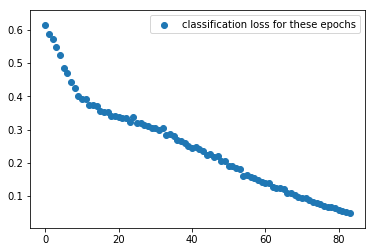

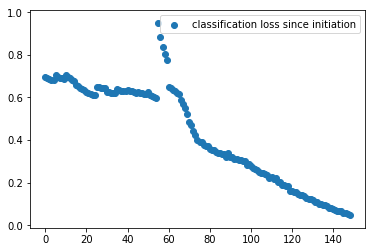

classification loss on last batch was: 0.04831210350401808


In [4]:
mixed_curriculum_train(rnnDeep,train_set,stop_threshold = 0.05)
#Deep hit exit threshold

In [5]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnnDeep.classify_word(w)==True),None)
neg = next((w for w in all_words if rnnDeep.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]

In [6]:
rnnDeep.renew()

provided counterexamples are: ['i', 's']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 2


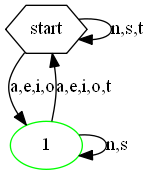

['', 'e']
refining, H size is 1
split wasn't perfect: gotta start over
['s', 'n']
returning counterexample of length 2:		to, this counterexample is rejected by the given RNN.
equivalence checking took: 0.46620349900000235
obs table refinement took 0.04
guided starting equivalence query for DFA of size 8


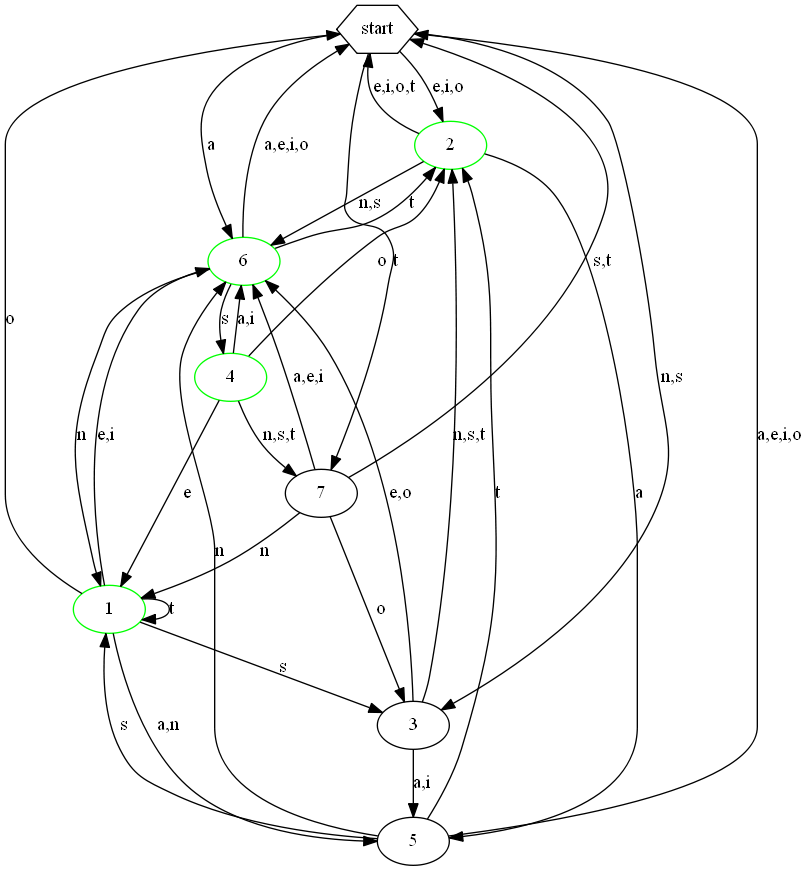

['s', 'n']
['ta', 'ti']
['', 'an']
refining, H size is 1
['aa', 'oa']
refining, H size is 1
['ao', 'oo']
['oe', 'oi']
returning counterexample of length 2:		sa, this counterexample is accepted by the given RNN.
equivalence checking took: 0.13817292999999609
obs table refinement took 0.097
guided starting equivalence query for DFA of size 16


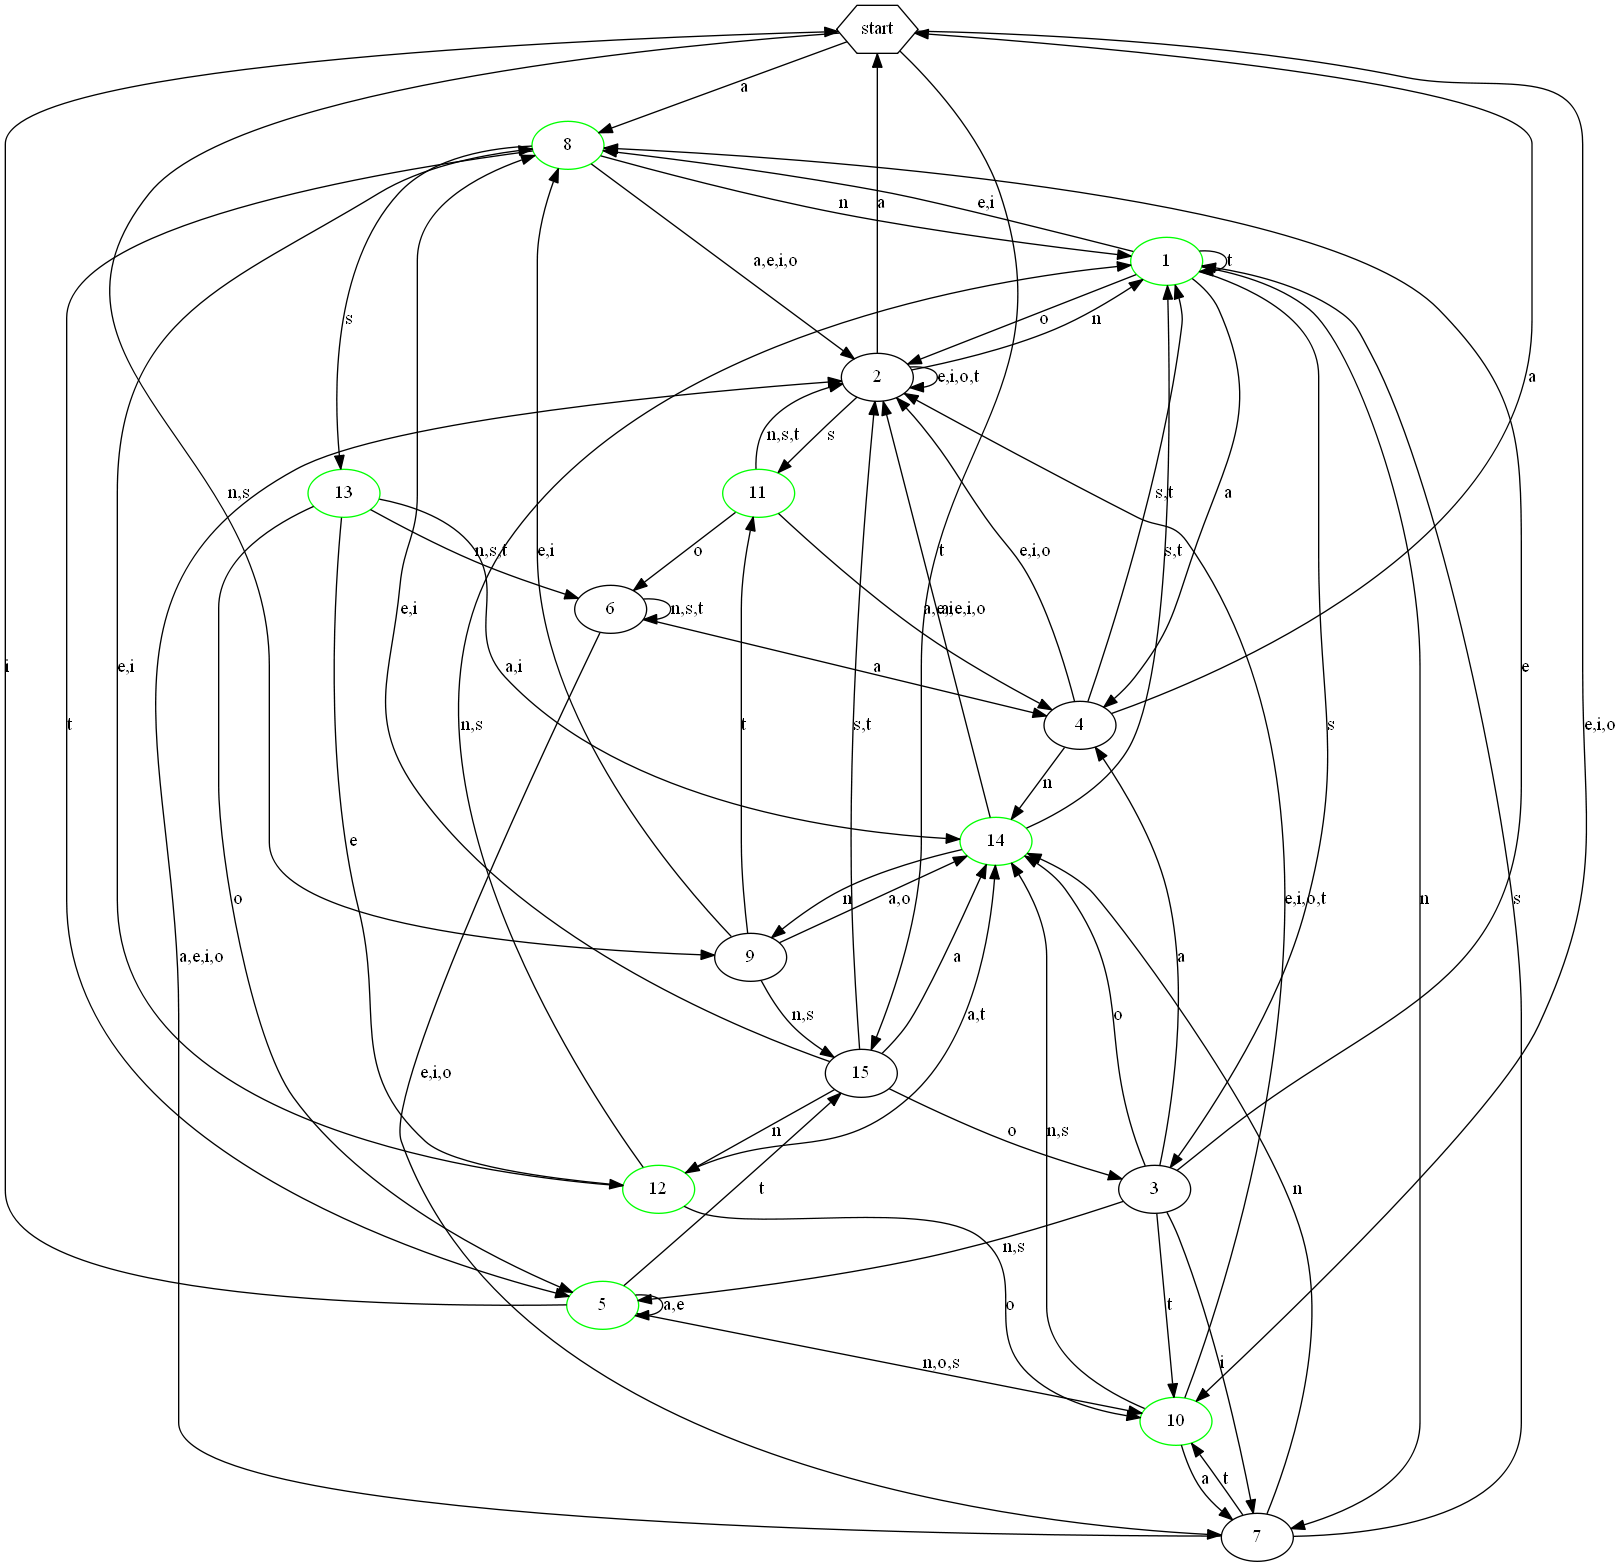

['s', 'n']
['ta', 'ti']
returning counterexample of length 3:		tan, this counterexample is accepted by the given RNN.
equivalence checking took: 0.2877659739999956
obs table refinement took 0.486
guided starting equivalence query for DFA of size 41
['s', 'n']
['ta', 'ti']
returning counterexample of length 4:		tise, this counterexample is rejected by the given RNN.
equivalence checking took: 0.012119387999987907
obs table refinement took 1.899
guided starting equivalence query for DFA of size 97
['s', 'n']
['ta', 'ti']
returning counterexample of length 4:		tits, this counterexample is rejected by the given RNN.
equivalence checking took: 0.011664873000000853
obs table refinement took 2.646
guided starting equivalence query for DFA of size 148
['s', 'n']
returning counterexample of length 3:		sen, this counterexample is accepted by the given RNN.
equivalence checking took: 0.004768451000003893
obs table refinement took 14.667
guided starting equivalence query for DFA of size 314
['s', 

In [7]:
dfaDeep = extract(rnnDeep,time_limit = 120, initial_split_depth = 10, starting_examples = starting_examples)

# Train and Extract with a wide network

In [3]:
rnnWide = RNNClassifier(ALPHABET,num_layers=5,hidden_dim=5,RNNClass = LSTMNetwork)

The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.


current average loss is:  0.6025525751234103
current average loss is:  0.45115672705554155
current average loss is:  0.3811404413786255
current average loss is:  0.3526783236185042
current average loss is:  0.33895359357365024


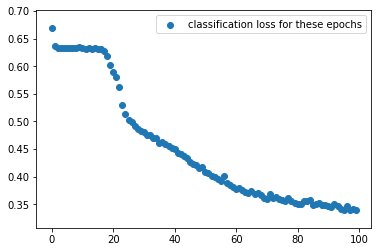

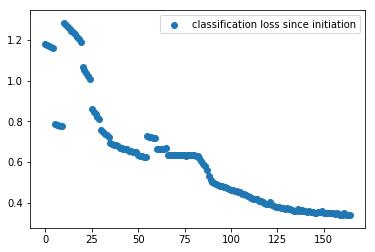

current average loss is:  0.3266057024326071
current average loss is:  0.3217327168632293
current average loss is:  0.31672161333317944
current average loss is:  0.3121385672948209
current average loss is:  0.3079071044921875


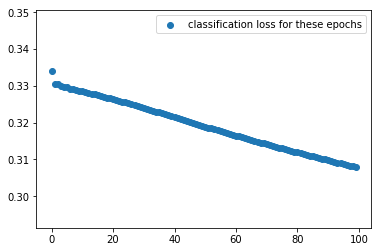

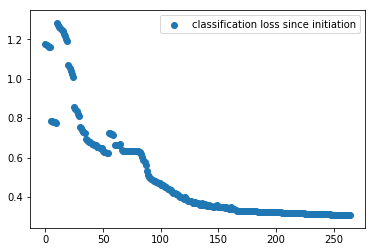

current average loss is:  0.31278293989285694
current average loss is:  0.3035879676832872
current average loss is:  0.2854809491824704
current average loss is:  0.279814586619369
current average loss is:  0.2666765042713711


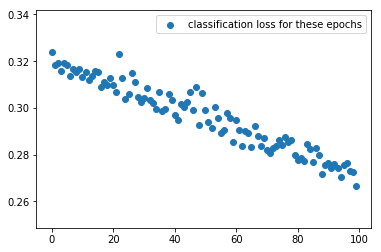

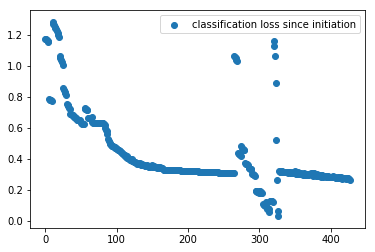

current average loss is:  0.2511129675094627
current average loss is:  0.24646593372790113
current average loss is:  0.24264350564300222
current average loss is:  0.23962517291791682
current average loss is:  0.23643921890146094


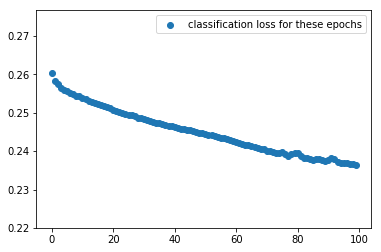

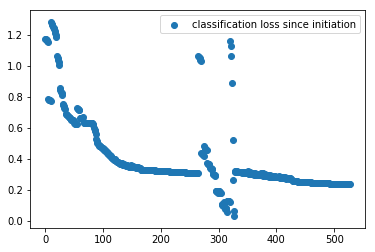

current average loss is:  0.25201614123432586
current average loss is:  0.23996742401553797
current average loss is:  0.22463709254349984
current average loss is:  0.22464718109920243
current average loss is:  0.22490104152625348


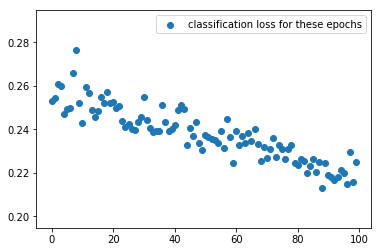

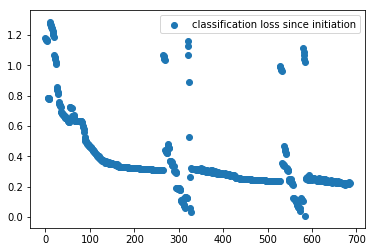

current average loss is:  0.19415733979759048
current average loss is:  0.1909000053011332
current average loss is:  0.18770969002074295
current average loss is:  0.1839637249223943
current average loss is:  0.1801619085990872


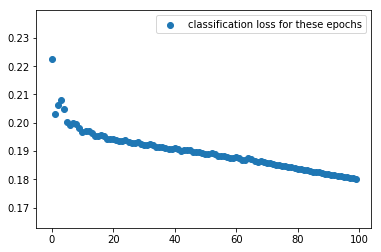

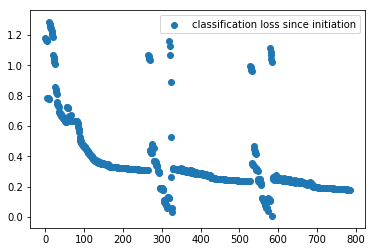

classification loss on last batch was: 0.1801619085990872


In [4]:
mixed_curriculum_train(rnnWide,train_set,stop_threshold = 0.05)
#Wide got as low as 0.18

In [5]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnnWide.classify_word(w)==True),None)
neg = next((w for w in all_words if rnnWide.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]

In [6]:
rnnWide.renew()

provided counterexamples are: ['i', 'so']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 1


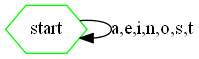

storing provided counterexample of length 2
returning counterexample of length 2:		so, this counterexample is rejected by the given RNN.
equivalence checking took: 0.03911438199997974
obs table refinement took 0.016
guided starting equivalence query for DFA of size 4


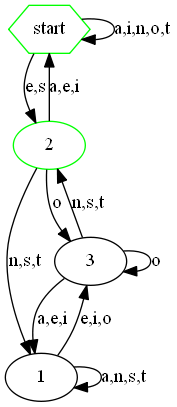

['', 'e']
returning counterexample of length 2:		es, this counterexample is accepted by the given RNN.
equivalence checking took: 0.04456115700003238
obs table refinement took 0.108
guided starting equivalence query for DFA of size 14


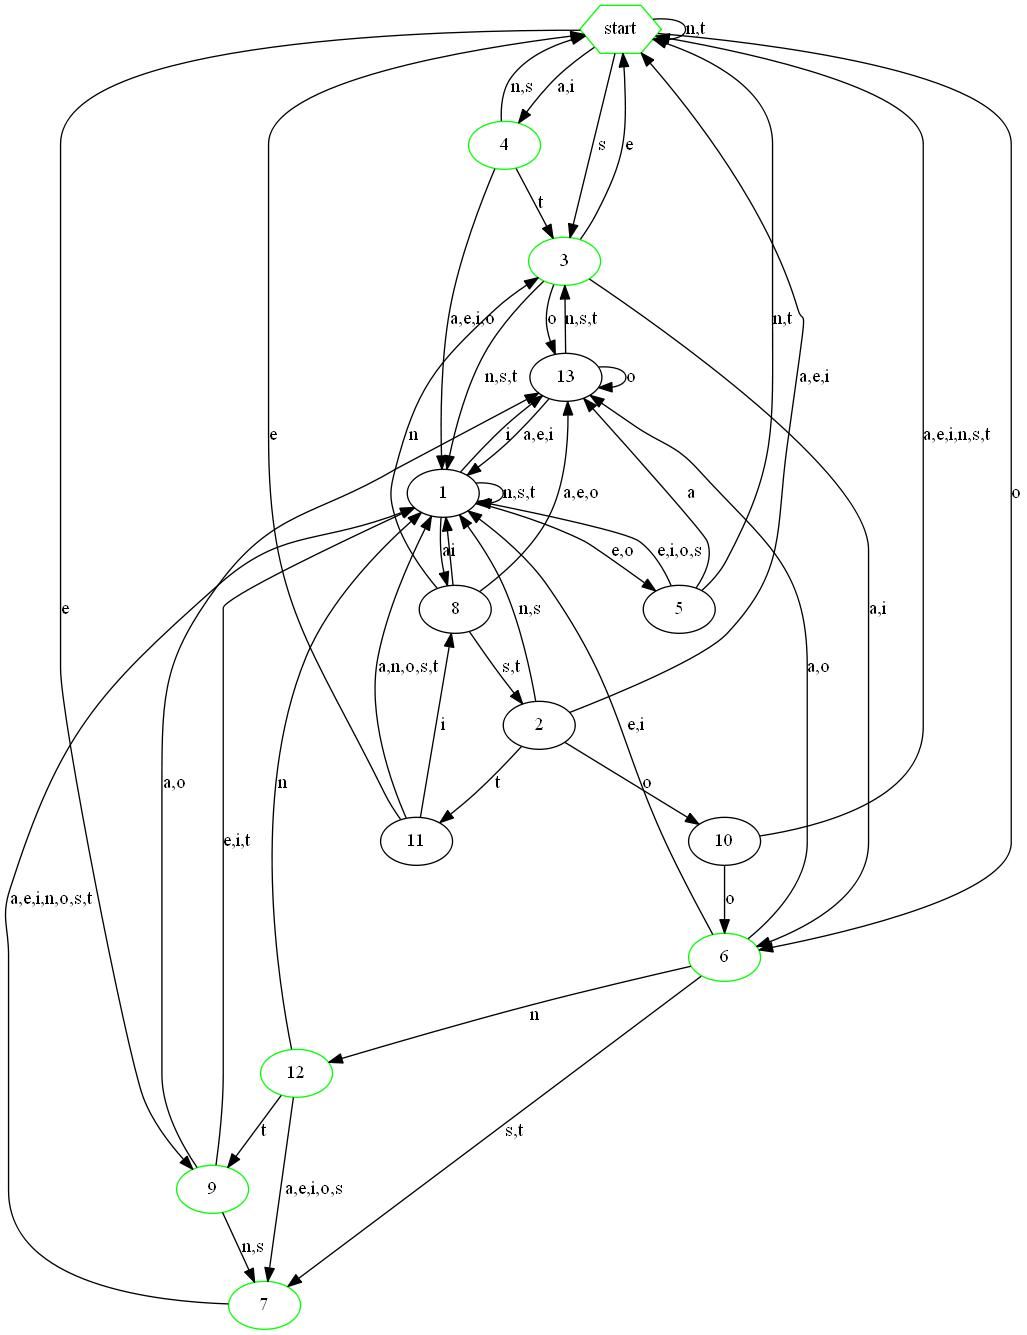

['', 'e']
refining, H size is 1
split wasn't perfect: gotta start over
['e', 'i']
returning counterexample of length 4:		ioen, this counterexample is rejected by the given RNN.
equivalence checking took: 0.2390827530000479
obs table refinement took 0.807
guided starting equivalence query for DFA of size 35
['e', 'i']
refining, H size is 1
['t', 'n']
['e', 'ee']
refining, H size is 1
['ea', 'eo']
refining, H size is 1
['ea', 'ei']
returning counterexample of length 4:		eaot, this counterexample is rejected by the given RNN.
equivalence checking took: 0.012295675000018491
obs table refinement took 0.706
guided starting equivalence query for DFA of size 51
['t', 'n']
['ea', 'ei']
returning counterexample of length 3:		eis, this counterexample is accepted by the given RNN.
equivalence checking took: 0.009387952999986737
obs table refinement took 2.531
guided starting equivalence query for DFA of size 108
['t', 'n']
['ea', 'ei']
refining, H size is 1
['ta', 'to']
refining, H size is 1
['tt'

In [7]:
dfaWide = extract(rnnWide,time_limit = 120, initial_split_depth = 10, starting_examples = starting_examples)

# Train and Extract with the optimal network

In [ ]:
rnnOpt = RNNClassifier(ALPHABET,num_layers=2,hidden_dim=50,RNNClass = LSTMNetwork)

In [ ]:
mixed_curriculum_train(rnnOpt,train_set,stop_threshold = 0.05)

In [ ]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnnOpt.classify_word(w)==True),None)
neg = next((w for w in all_words if rnnOpt.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]

In [ ]:
rnnWide.renew()

In [ ]:
dfaOpt = extract(rnnOpt,time_limit = 120, initial_split_depth = 10, starting_examples = starting_examples)

#### 3.4. Get stats
Display the extracted DFA by using the `draw_nicely` function, which has optional parameters `maximum` (default $60$) and `force` (default `False`), and will only draw the DFA if it has less than `maximum` states or `force` is set to `True`.

Print some statistics you might find interesting about the network, such as the trained RNN's accuracy against its target, the extracted DFA's accuracy against the RNN, and the extracted DFA's accuracy against the original RNN's target.

In [11]:
'''
from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfa.draw_nicely(maximum=30) #max size willing to draw

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")
'''

NameError: name 'dfa' is not defined

Rotation Cypher Checker

In [12]:
def rtCyCdecode(message):  # Rotation cypher decode
    msgList = list(message.lower())
    letterList = ['a', 'e', 'i', 'n', 'o', 's', 't']
    convertedMsgList = []

    for i in range(1, len(letterList)):
        convertedMsg = ""
        for letter in msgList:
            lIndex = letterList.index(letter)
            newLIndex = (lIndex + i) % len(letterList)
            convertedMsg += letterList[newLIndex]
        convertedMsgList.append(convertedMsg)

    return convertedMsgList

In [13]:
@profile(precision=8)
def checkRNN(convertedMsgList):
    for convertedMsg in convertedMsgList:
        if rnn.classify_word(convertedMsg):
            print("Cyphered Message is English", convertedMsg, "in RNN")
            return True

In [14]:
@profile(precision=8)
def checkDFA(convertedMsgList):
    for convertedMsg in convertedMsgList:
        if dfa.classify_word(convertedMsg):
            print("Cyphered Message is English", convertedMsg, "in DFA")
            return True

In [15]:
def rtCyChecker(message):  # Rotation cypher checker
    convertedMsgList = rtCyCdecode(message)
    foundKeyRNN = False
    foundKeyDFA = False
    print("Try message in following list", '\n', convertedMsgList)

    startRNN = time.time()
    if checkRNN(convertedMsgList):
        foundKeyRNN = True
    executeTimeRNN = time.time() - startRNN
    print("RNN execution time", executeTimeRNN)

    startDFA = time.time()
    if checkDFA(convertedMsgList):
        foundKeyDFA = True
    executeTimeDFA = time.time() - startDFA
    print("DFA execution time", executeTimeDFA)

    if foundKeyRNN != foundKeyDFA:
        print("RNN and DFA returned different result")

    if not foundKeyRNN and not foundKeyDFA:
        print("No rotation cyphered message founded")

In [16]:
rtCyChecker(message)        # Call above functions

NameError: name 'message' is not defined